In [1]:
import gc
import cv2
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from shared.local_path import *
from shared.utils import *

### Read Image Data

In [2]:
TRAIN_IMAGE_PATH = R'E:\Skripsi\data\temp\new_lagi\train'
BATCH_SIZE = 8

In [3]:
filepath = []
label = []

i = 0
for classes in os.listdir(TRAIN_IMAGE_PATH):
    for file in os.listdir(os.path.join(TRAIN_IMAGE_PATH, classes)):
        path = os.path.join(TRAIN_IMAGE_PATH, classes, file)
        filepath.append(path)
        label.append(classes)

train_df = pd.DataFrame({
    'filepath': filepath,
    'label': label
})

del filepath, label

print(train_df.shape)
print(train_df['label'].unique())
train_df.head()

(175, 2)
['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


,filepath,label
0,E:\Skripsi\data\temp\new_lagi\train\angry\13.jpg,angry
1,E:\Skripsi\data\temp\new_lagi\train\angry\a.jpeg,angry
2,E:\Skripsi\data\temp\new_lagi\train\angry\a.jpg,angry
3,E:\Skripsi\data\temp\new_lagi\train\angry\a.png,angry
4,E:\Skripsi\data\temp\new_lagi\train\angry\a10.jpg,angry


In [4]:
# filepath = []
# label = []
# 
# i = 0
# for classes in os.listdir(TEST_IMAGE_PATH):
#     for file in os.listdir(os.path.join(TEST_IMAGE_PATH, classes)):
#         path = os.path.join(TEST_IMAGE_PATH, classes, file)
#         filepath.append(path)
#         label.append(classes)
# 
# img_test_df = pd.DataFrame({
#     'filepath': filepath,
#     'label': label
# })
# 
# del filepath, label
# 
# print(img_test_df.shape)
# print(img_test_df['label'].unique())
# img_test_df.head()

In [5]:
le = LabelEncoder()
le.fit(train_df['label'])
train_df['label_encoded'] = le.transform(train_df['label'])
# img_test_df['label_encoded'] = le.transform(img_test_df['label'])

## transform the filepath into image data

In [6]:
def preprocess_image(img_path, dsize: tuple = (224, 224), normalize=False, augment=False, rescale: float = None,
                     preprocess_function=None):
    if preprocess_function is not None and not callable(preprocess_function):
        raise ValueError("preprocess_function must be a callable function.")

    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=dsize)
    if normalize and rescale is None:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = (image - mean) / std

    if rescale is not None and not normalize:
        image = np.array(image) * rescale

    if augment:
        # Choose one augmentation randomly
        augmentations = ['flip_horizontal', 'flip_vertical', 'rotate', ]
        chosen_aug = random.choice(augmentations)

        if chosen_aug == 'flip_horizontal':
            image = cv2.flip(image, 1)
        elif chosen_aug == 'flip_vertical':
            image = cv2.flip(image, 0)
        elif chosen_aug == 'rotate':
            # Random rotation between -30 and 30 degrees
            angle = random.uniform(-30, 30)
            h, w = image.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
        elif chosen_aug == 'zoom':
            # Random zoom between 0.8x and 1.2x
            zoom_factor = random.uniform(0.8, 1.2)
            h, w = image.shape[:2]
            new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
            if zoom_factor > 1.0:
                # Zoom in: crop the center
                resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
                start_x = (new_w - w) // 2
                start_y = (new_h - h) // 2
                image = resized[start_y:start_y + h, start_x:start_x + w]
            else:
                # Zoom out: pad with replicated borders
                resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LANCZOS4)
                pad_x = (w - new_w) // 2
                pad_y = (h - new_h) // 2
                image = cv2.copyMakeBorder(resized, pad_y, pad_y, pad_x, pad_x,
                                           cv2.BORDER_REPLICATE)

    if preprocess_function is not None:
        return np.array(preprocess_function(image))
    return image

In [7]:
with tf.device('/GPU:0'):
    train_df['data'] = train_df['filepath'].apply(
        lambda x: preprocess_image(x, preprocess_function=tf.keras.applications.vgg19.preprocess_input,
                                   augment=True))
    # img_test_df['data'] = img_test_df['filepath'].apply(
    #     lambda x: preprocess_image(x, (100, 100), preprocess_function=tf.keras.applications.vgg19.preprocess_input)
    # )


## Split and Shuffle Dataset into train, val, and test

In [8]:
# Image Data
# train_df = train_df.sample(frac=1, random_state=19).reset_index(drop=True)
train_df, img_val_df = train_test_split(train_df, test_size=.2, random_state=100, shuffle=True)

## Downsampling with following least dataset amount

In [9]:
# train_df, audio = downsample_df(train_df, audio)
# img_val_df, aud_val_df = downsample_df(img_val_df, aud_val_df)
# img_test_df, aud_test_df = downsample_df(img_test_df, aud_test_df)

In [10]:
# print(len(train_df))
# print(len(img_val_df))
# print(len(img_test_df))
# 
# print("===============================")
# 
# print(len(audio))
# print(len(aud_val_df))
# print(len(aud_test_df))

## Convert to Numpy

In [11]:
# # Audio Data
# x_audio_train = np.stack(audio['data'].values)
# y_audio_train = np.array(audio['label_encoded'].values)
# 
# x_audio_val = np.stack(aud_val_df['data'].values)
# y_audio_val = np.array(aud_val_df['label_encoded'].values)
# 
# x_audio_test = np.stack(aud_test_df['data'].values)
# y_audio_test = np.array(aud_test_df['label_encoded'].values)

In [12]:
train_df.data.iloc[1].shape

(224, 224, 3)

In [13]:
x_img_train = np.stack(train_df['data'].values)
y_img_train = np.array(train_df['label_encoded'].values)

x_img_val = np.stack(img_val_df['data'].values)
y_img_val = np.array(img_val_df['label_encoded'].values)

# x_img_test = np.stack(img_test_df['data'].values)
# y_img_test = np.array(img_test_df['label_encoded'].values)

In [14]:
del train_df, img_val_df, # img_test_df

# Modeling
## Creating Model

In [15]:
base = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None
)

for layer in base.layers:
    layer.trainable = False


In [35]:
input_image = tf.keras.Input(shape=(224, 224, 3), name='input_image')

left = base(input_image)
left = tf.keras.layers.GlobalAveragePooling2D()(left)
# left = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(0.01))(left)
# left = tf.keras.layers.Dense(512, activation='relu')(left)
# left = tf.keras.layers.Dense(512, activation='relu')(left)
out1 = tf.keras.layers.Dense(7, activation='softmax', name='image_class')(left)

model = tf.keras.models.Model(input_image, out1)

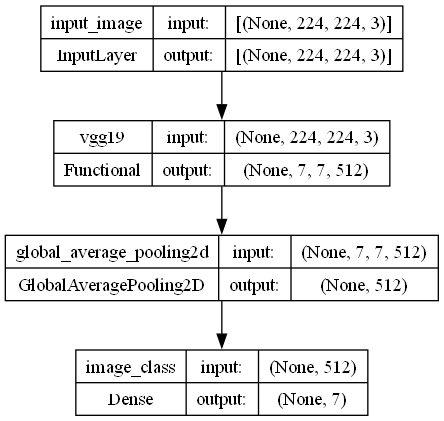

In [36]:
plot_model(model, show_shapes=True, show_layer_names=True)

## Compile the model

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics='accuracy',
)

In [38]:
tf.keras.backend.clear_session()
gc.collect()

11076

In [39]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    mode='min',
    # start_from_epoch=2,
    patience=5
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join('model', 'best_model.keras'),
    verbose=2,
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                    factor=0.1,
                                                    min_lr=1e-6,
                                                    patience=3,
                                                    mode='min'
                                                    )

## Train the model

In [40]:
gc.collect()
tf.keras.backend.clear_session()

In [41]:
history = model.fit(
    x=x_img_train,
    y=y_img_train,
    validation_data=(
        x_img_val,
        y_img_val
    ),
    callbacks=[lr_scheduler],
    epochs=100,
    batch_size=BATCH_SIZE,
    steps_per_epoch=len(x_img_train) // BATCH_SIZE,
    validation_steps=len(x_img_val) // BATCH_SIZE,
)


Epoch 1/100
17/17 [==============================] - 2s 56ms/step - loss: 3.9749 - accuracy: 0.1324 - val_loss: 2.8613 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/100
17/17 [==============================] - 1s 48ms/step - loss: 2.8537 - accuracy: 0.1515 - val_loss: 2.4287 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 3/100
17/17 [==============================] - 1s 47ms/step - loss: 2.1202 - accuracy: 0.2424 - val_loss: 2.3281 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/100
17/17 [==============================] - 1s 50ms/step - loss: 1.7088 - accuracy: 0.4015 - val_loss: 2.1520 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/100
17/17 [==============================] - 1s 47ms/step - loss: 1.4148 - accuracy: 0.4848 - val_loss: 2.0395 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 6/100
17/17 [==============================] - 1s 46ms/step - loss: 1.1086 - accuracy: 0.6136 - val_loss: 2.0370 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 7/100
17/17 [==============================] - 1s 46ms/step - lo

## Plot the training result

In [42]:
def plot_and_save(metric_name, history, ylabel, filename):
    plt.figure()
    plt.plot(history.history[metric_name], label=f'Train {ylabel}')
    if f'val_{metric_name}' in history.history:
        plt.plot(history.history[f'val_{metric_name}'], label=f'Val {ylabel}')
    plt.title(f'{ylabel} over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

In [43]:
plot_and_save('loss', history, 'Loss', 'image_loss_plot.png')
plot_and_save('accuracy', history, 'Image Classification Accuracy', 'image_class_accuracy_plot.png')

# Evaluation
## Using model.evaluate

In [44]:
gc.collect()
tf.keras.backend.clear_session()

In [45]:
model.evaluate(x_img_val, y_img_val, batch_size=BATCH_SIZE, verbose=2,
               steps=len(x_img_val) // BATCH_SIZE)

4/4 - 0s - loss: 1.9447 - accuracy: 0.4375 - 198ms/epoch - 49ms/step


[1.9446958303451538, 0.4375]

In [46]:
# model.evaluate(x_img_test, y_img_test, batch_size=BATCH_SIZE, verbose=2,
#                steps=len(x_img_test) // BATCH_SIZE)

## Using confusion matrix

In [47]:
predictions = model.predict(x_img_val)
predictions = np.argmax(predictions, axis=1)

classes = [x for x in os.listdir(TRAIN_IMAGE_PATH)]
print(classes)

2/2 [==============================] - 0s 108ms/step
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### Plot the confusion Matrix

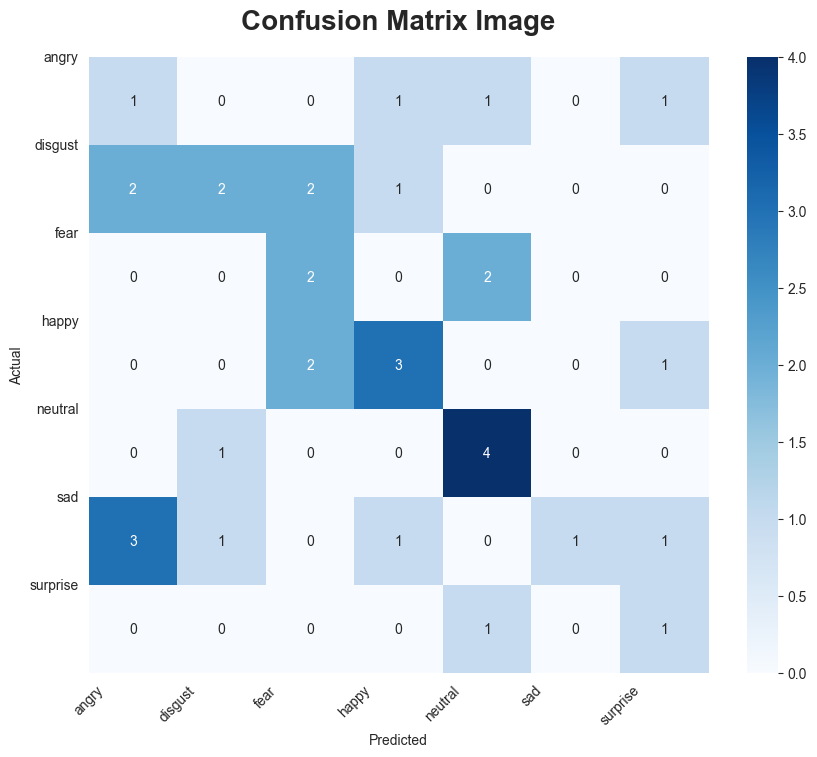

In [48]:
cm = confusion_matrix(y_img_val, predictions)
plt.figure(figsize=(10, 8))  # Set the figure size if needed
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix Image', pad=20, fontsize=20, fontweight="bold")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.xticks(ticks=range(len(classes)), labels=classes, rotation=45)
plt.yticks(ticks=range(len(classes)), labels=classes, rotation=0)
plt.savefig('confusion_matrix_image.png', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
# plt.figure(figsize=(10, 8))  # Set the figure size if needed
# sns.heatmap(audio_cm, annot=True, cmap='Blues', fmt='g')
# 
# plt.title('Confusion Matrix Audio', pad=20, fontsize=20, fontweight="bold")
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# 
# plt.xticks(ticks=range(len(aud_classes)), labels=aud_classes, rotation=45)
# plt.yticks(ticks=range(len(aud_classes)), labels=aud_classes, rotation=0)
# plt.savefig('confusion_matrix_audio.png', dpi=300, bbox_inches='tight')
# plt.show()

In [50]:
print(classification_report(y_img_val, predictions))

              precision    recall  f1-score   support

           0       0.17      0.25      0.20         4
           1       0.50      0.29      0.36         7
           2       0.33      0.50      0.40         4
           3       0.50      0.50      0.50         6
           4       0.50      0.80      0.62         5
           5       1.00      0.14      0.25         7
           6       0.25      0.50      0.33         2

    accuracy                           0.40        35
   macro avg       0.46      0.43      0.38        35
weighted avg       0.53      0.40      0.38        35



In [51]:
# print(classification_report(y_audio_test, audio_class))

In [33]:
model.save('model_sc4t5_img.h5')